# pNEUMA simulator

Data from: https://open-traffic.epfl.ch

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{jam})) \},$ \
$V'(s) = H(s -s_{jam})\lambda\exp(-\lambda v_0^{-1}(s -s_{jam})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{jam},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n(t) = -b^{-1}\varepsilon_n(t) +\sigma_R\sqrt{2 b^{-1}} \xi_n(t),\ b>0,\\
    \dot v_n(t) = \tau_n^{-1}[{\{{ V_n(s_n(t))+\varepsilon_n(t)}\}-v_n(t)}],\ \tau_n>0,\\
    \dot x_n(t) = v_n(t).
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{\{{V_n^{\tilde p}(s_n(t)) +\varepsilon_n(t+\delta) }\}-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min(d_{\max}, v_0 \Delta t(\alpha))
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{des} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha_n(t) = \tau^{-1}\left[\alpha_n^{des}(t)-\alpha_n(t)\right]
\end{equation}$

In [22]:
import os
import json
import zipfile
import logging
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from joblib import Parallel, delayed
from matplotlib import rcParams
from tqdm.notebook import tqdm
from scipy.stats import iqr
from numpy.linalg import norm
from numpy import array, arange, where, zeros
from math import exp

In [23]:
from pNeuma_simulator import params, batch, ring, zipdir
from pNeuma_simulator.results import normalized, loader, aggregate
from pNeuma_simulator.initialization import PoissonDisc, ov
from pNeuma_simulator.utils import radial

In [24]:
warnings.filterwarnings("ignore")
rcParams["animation.embed_limit"] = 2**128
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

## 2D simulator

In [25]:
# Pseudorandom number generator
seed = 0
rng = np.random.default_rng(seed)
n_cars = 8
n_moto = 6
sampler = PoissonDisc(
    n_cars, n_moto, cell=params.cell, L=params.L, W=params.cell * 3, k=params.k, clearance=params.clearance, rng=rng
)
samples, images = sampler.sample(rng)
c_samples = samples[: 2 * n_cars]
m_samples = samples[2 * n_cars :]
markings = arange(-sampler.W / 2, 3 * sampler.W / 4, sampler.W / 2)

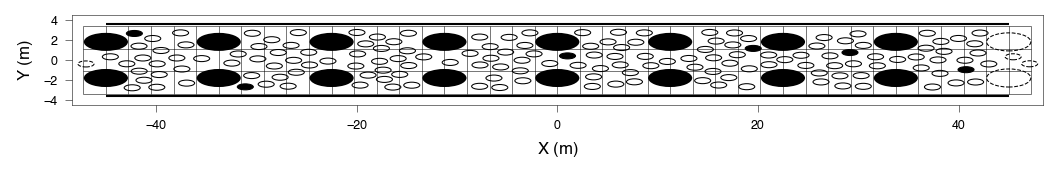

In [26]:
fig, ax = plt.subplots(figsize=(2 * 8.7 * params.cm, 2.5 * params.cm), dpi=150)
ax.set_aspect("equal")
for sample in samples:
    if sample in c_samples:
        sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.6}
    else:
        sample.styles = {"ec": "k", "fill": False, "lw": 0.5}
    sample.draw(ax)
for image in images:
    image.styles = {"ec": "k", "fill": False, "lw": 0.5, "ls": "--"}
    image.draw(ax)
for m_sample in rng.choice(m_samples, n_moto, replace=False):
    m_sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.5}
    m_sample.draw(ax)
ax.hlines(
    [-params.lane, params.lane],
    xmin=-sampler.width / 2,
    xmax=sampler.width / 2,
    color="k",
    ls="-",
    lw=1,
)
ax.vlines(
    sampler.x_boundaries,
    ymin=-3 * sampler.cell / 2,
    ymax=3 * sampler.cell / 2,
    color="k",
    lw=0.25,
)
ax.hlines(
    sampler.y_boundaries,
    xmin=-sampler.nx * sampler.cell / 2,
    xmax=sampler.nx * sampler.cell / 2,
    color="k",
    lw=0.25,
)
plt.xlim(-(sampler.nx + 1) * sampler.cell / 2, (sampler.nx + 1) * sampler.cell / 2)
plt.ylim(-2 * sampler.cell, 2 * sampler.cell)
ax.set_xlabel("X ($m$)")
ax.set_ylabel("Y ($m$)")
ax.set_yticks(arange(-4, 5, 2))
fig.tight_layout(pad=0)
# plt.savefig(f"darts.pdf", format="pdf", transparent=True)

In [27]:
param = {"const": 4.026397, "x1": -0.062306}
phi_max = int(exp(param["x1"] * 0 * params.factor + param["const"]))
phi_max

56

In [28]:
# Space discretization
x = arange(-params.L / 2 + params.grid / 2, params.L / 2, params.grid)
y = arange(-params.lane - params.grid / 2, params.lane + params.grid, params.grid)
xv, yv = np.meshgrid(x, y)
yv = np.flip(yv)
shape = yv.shape

In [29]:
path = "./output/"
os.makedirs(path, exist_ok=True)
# Combinatorial configurations
n_veh = 4
scale = 2
l_cars = scale * arange(1, n_veh, 1)
l_moto = scale * arange(0, n_veh - 1, 1)
permutations = list(itertools.product(l_cars, l_moto))
len(permutations)

9

In [ ]:
run = True

epochs = 1
default_rng = np.random.default_rng(1234)
seeds = default_rng.integers(1e8, size=epochs * len(permutations))
if run:
    with Parallel(n_jobs=-1, prefer="processes") as master:
        for n, permutation in tqdm(enumerate(permutations)):
            start = n * epochs
            end = (n + 1) * epochs
            # if permutation[1] in [0]: 
            # Unclear why this is there. This makes the code run for only 
            # permutations with 0 motorcycles
            items = master(
                delayed(batch)(seed, permutation) for seed in seeds[start:end]
            )
            print(f"Permutation: {permutation}")
            # Dump result to a JSON data specification
            with open(f"{path}{permutation}.json", "w") as outfile:
                json.dump(items, outfile)
            # Compress as Zip and delete original JSON
            with zipfile.ZipFile(
                f"{path}{permutation}.zip", "w", zipfile.ZIP_DEFLATED
            ) as zipf:
                zipdir(path, zipf)


0it [00:00, ?it/s]

Permutation: (np.int64(2), np.int64(0))


# Results

In [ ]:
# consider only this last fraction of the simulated data
keep = 1 / 3

In [ ]:
read = False
path = "./output/"
os.makedirs(path, exist_ok=True)
if read:
    with open(f"{path}results.json", "r") as openfile:
        results = json.load(openfile)

In [ ]:
probe = False
if probe:
    permutation = (4, 6)
    items = loader(permutation, path)
    accidents = 0
    locations = []
    for item in items:
        if isinstance(item[0], list):
            pass
        else:
            locations.append(item)
            accidents += 1
    error = accidents / len(items)
    print(error)

In [ ]:
# Compile the results
compile = True
if compile:
    if read == False:
        results = {}
    for permutation in permutations:
        if permutation[1] in [0]:
            n_cars, n_moto = permutation
            results[str(permutation)] = {
                "VKT": [],
                "VHT": [],
                "VKT_cars": [],
                "VHT_cars": [],
                "E_cars": [],
                "VKT_moto": [],
                "VHT_moto": [],
                "E_moto": [],
                "risk": [],
            }
            items = loader(permutation, path)
            accidents = 0
            for item in items:
                if isinstance(item[0], list):
                    (
                        VKT,
                        VHT,
                        VKT_cars,
                        VHT_cars,
                        E_cars,
                        VKT_moto,
                        VHT_moto,
                        E_moto,
                        risk,
                    ) = aggregate(item[0], n_cars, n_moto, params.d_max)
                    results[str(permutation)]["VKT"].append(VKT)
                    results[str(permutation)]["VHT"].append(VHT)
                    results[str(permutation)]["VKT_cars"].append(VKT_cars)
                    results[str(permutation)]["VHT_cars"].append(VHT_cars)
                    results[str(permutation)]["E_cars"].append(E_cars)
                    results[str(permutation)]["VKT_moto"].append(VKT_moto)
                    results[str(permutation)]["VHT_moto"].append(VHT_moto)
                    results[str(permutation)]["E_moto"].append(E_moto)
                    results[str(permutation)]["risk"].append(risk)
                else:
                    accidents += 1
            error = accidents / len(items)
            results[str(permutation)]["error"] = error
            items = None

In [ ]:
write = True
path = "./output/"
os.makedirs(path, exist_ok=True)
if write:
    with open(f"{path}results.json", "w") as outfile:
        json.dump(results, outfile)

In [ ]:
read = True
path = "./output/"
os.makedirs(path, exist_ok=True)
if read:
    with open(f"{path}results.json", "r") as openfile:
        results = json.load(openfile)

In [ ]:
for permutation in permutations:
    str_permutation = str(permutation)
    print(f"Permutation: {permutation}")

In [ ]:
results

In [ ]:
l_flow = []
l_flow_cars = []
l_flow_moto = []
l_speed = []
l_speed_cars = []
l_speed_moto = []
l_iqr_cars = []
l_iqr_moto = []
l_delta = []
l_error = []
l_risk = []
for permutation in permutations:
    if permutation[1] in [0]:
        speed = np.nanmean(results[str(permutation)]["VKT"]) / np.nanmean(
            results[str(permutation)]["VHT"]
        )
        speed_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / np.nanmean(
            results[str(permutation)]["VHT_cars"]
        )
        iqr_cars = iqr(
            results[str(permutation)]["VKT_cars"], nan_policy="omit"
        ) / np.nanmean(results[str(permutation)]["VHT_cars"])
        flow = np.nanmean(results[str(permutation)]["VKT"]) / (
            (keep * params.T / 3600) * (2 * params.L / 1000)
        )
        flow_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / (
            (keep * params.T / 3600) * (2 * params.L / 1000)
        )
        if permutation[1] > 0:
            speed_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / np.nanmean(
                results[str(permutation)]["VHT_moto"]
            )
            iqr_moto = iqr(
                results[str(permutation)]["VKT_moto"], nan_policy="omit"
            ) / np.nanmean(results[str(permutation)]["VHT_moto"])
            flow_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / (
                (keep * params.T / 3600) * (2 * params.L / 1000)
            )
            delta = np.nanmean(results[str(permutation)]["E_moto"]) - np.nanmean(
                results[str(permutation)]["E_cars"]
            )
            risk = np.nanmean(results[str(permutation)]["risk"])
        else:
            speed_moto = np.nan
            iqr_moto = np.nan
            flow_moto = np.nan
            delta = np.nan
            risk = np.nan
        error = results[str(permutation)]["error"]
        l_flow.append(flow)
        l_flow_cars.append(flow_cars)
        l_flow_moto.append(flow_moto)
        l_speed.append(speed)
        l_speed_cars.append(speed_cars)
        l_speed_moto.append(speed_moto)
        l_iqr_cars.append(iqr_cars)
        l_iqr_moto.append(iqr_moto)
        l_delta.append(delta)
        l_error.append(error)
        l_risk.append(risk)

In [ ]:
rounding = 5
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
car_density = 1e3 * np.round((car_matrix) / params.L, rounding)
moto_density = 1e3 * np.round((moto_matrix) / (2 * params.L), rounding)
flow_matrix = array(l_flow).reshape((n_veh - 1, n_veh - 1))
flow_matrix_cars = array(l_flow_cars).reshape((n_veh - 1, n_veh - 1))
flow_matrix_moto = array(l_flow_moto).reshape((n_veh - 1, n_veh - 1))
risk_matrix = array(l_risk).reshape((n_veh - 1, n_veh - 1))
speed_matrix = array(l_speed).reshape((n_veh - 1, n_veh - 1))
speed_matrix_cars = array(l_speed_cars).reshape((n_veh - 1, n_veh - 1))
speed_matrix_moto = array(l_speed_moto).reshape((n_veh - 1, n_veh - 1))
iqr_matrix_cars = array(l_iqr_cars).reshape((n_veh - 1, n_veh - 1))
iqr_matrix_moto = array(l_iqr_moto).reshape((n_veh - 1, n_veh - 1))
error_matrix = array(l_error).reshape((n_veh - 1, n_veh - 1))
delta_matrix = array(l_delta).reshape((n_veh - 1, n_veh - 1))
percent_matrix = np.round(moto_matrix / (2 * car_matrix + moto_matrix), rounding)

## Rejection rate

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    error_matrix,
    levels=arange(0.1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
_ = plt.imshow(error_matrix.T, origin="lower")

In [ ]:
_ = plt.plot(error_matrix[-1], c="k")

## Effect of traffic composition on the capacity

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CD = ax.contour(
    car_density,
    moto_density,
    percent_matrix,
    levels=[0, 0.2, 0.3],
    colors=[
        "none",
        "k",
        "k",
    ],
    linestyles=[
        "-",
        "--",
        ":",
    ],
)
CS = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars / 1000,
    levels=arange(0, 1.6, 0.05),
    colors="k",
    frameon=True,
    linewidths=0.5,
)
ax.clabel(CS, CS.levels[::4][4:], inline=True, fontsize=6)
CS = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars,
    levels=arange(0, 1600, 1),
    colors="none",
    frameon=True,
    linewidths=0.5,
)
contours, l_points, l_response = normalized(CS, CD)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
fig.tight_layout(pad=0)
# plt.savefig(f"flow_surface.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(flow_matrix_cars.T, origin="lower")

In [ ]:
l_density = [
    78.85164336796137,
    80.21430502104938,
    81.76971482132372,
    84.2952412358987,
    121.4738292635279,
    126.26641429146008,
    129.25637641049116,
    132.76735019167575,
    136.07715448570178,
    139.55620001819193,
    140.61463808620402,
    143.44068363706938,
    147.31179201878675,
    55.277204341493906,
    56.350926415363226,
    56.728340987200056,
    59.15088612856629,
    47.49730502323255,
    47.88934040436746,
    57.64671875346068,
    58.15279998791782,
    59.00262311679693,
    59.839895783363254,
    67.74543008835644,
    85.85646285009275,
    88.13886959677079,
    90.813589412546,
    92.62579527487557,
    95.09407661086294,
    97.18538284222981,
    99.37074122699903,
    101.21331224133333,
    103.5857831721714,
    106.07214566317205,
    127.67537281967729,
    148.0210927334216,
    151.89620982152047,
    153.15095885255977,
    154.93836756645743,
    67.54819433406072,
    68.09284618743301,
    69.15848942390676,
    70.63181700666524,
    88.31011766872678,
    90.99282148135316,
    42.866514801061754,
    86.25373121166918,
    105.1148969935716,
    109.19596135736022,
    111.82669186663368,
    131.4579356178662,
    135.28949074125137,
    138.72787252345282,
    141.26102638279002,
    145.013847601388,
    147.7840554293003,
    80.14656707719867,
    81.1281440892312,
    88.98274159304249,
    100.22620105526924,
    103.35045179907183,
    105.46557297780107,
    106.92324136442195,
    108.67743619761646,
    111.28294271429696,
    114.57934532708677,
    118.2284520962177,
    120.84590917898109,
    122.44207397691194,
    124.41116276795671,
    125.93127139567115,
    127.48898604602456,
    130.3532186962445,
    134.70215310952977,
    137.08915451648053,
    141.47802606239614,
    53.708994790095524,
    54.210816156969244,
    42.30121005500219,
    42.76893332724363,
    33.847457586750686,
    74.0699377761518,
    109.57030073507198,
    113.59445814058193,
    116.00867202329493,
    118.37550144782684,
    120.84091986263321,
    122.92216595962665,
    125.92589397872716,
    131.08368980283393,
    136.6820472257816,
    149.69003222401113,
    154.67826099957523,
    73.42414686596992,
    75.14823533370938,
]
l_flow = [
    1558.0390273248458,
    1546.08105538972,
    1536.423693594767,
    1563.3005100398946,
    1178.0788527954155,
    1025.529308431304,
    1034.0376697399734,
    885.2577182971727,
    890.7181910575447,
    795.2277785736013,
    715.9356849125139,
    643.2863450707156,
    499.85247435434826,
    917.9660898864796,
    881.1661454829024,
    1457.8094140358965,
    1455.4988469635307,
    1174.542585524414,
    1137.8094812741908,
    1425.5245177454833,
    1466.2279320556374,
    1423.2511880505324,
    1472.4542604569156,
    1527.3576816256773,
    1509.022250248795,
    1420.965449839972,
    1408.9813979757166,
    1392.1987202958474,
    1337.106557463828,
    1331.265283872372,
    1300.9027626034924,
    1239.2550217286862,
    1205.447872494521,
    1170.0178738361903,
    510.6959480374308,
    663.8294493103753,
    533.9485994827373,
    482.81452544546846,
    469.53793878155653,
    1424.6828508167503,
    1411.4746581951968,
    1475.529256442378,
    1472.7253957843127,
    1552.1492717854715,
    1522.1920864073388,
    805.4509928448624,
    1526.5299661625768,
    1541.7883529109063,
    1588.320168709319,
    1463.9659738500616,
    1083.740224678931,
    1016.7227372364727,
    891.1374825203661,
    701.9861089717187,
    738.3347819645631,
    644.7278738607845,
    1573.8428515555174,
    1553.792234487093,
    1563.9655503885988,
    1482.313610175528,
    1352.9986995190175,
    1380.6884717577275,
    1347.9416489935177,
    1212.0161704967143,
    1187.1308696110573,
    1111.2141118304146,
    1017.5546007675445,
    908.1758513337813,
    920.1712585458981,
    874.6625674158905,
    778.6325179924138,
    649.1064420204723,
    663.6895863027673,
    538.8013127893385,
    481.89708505657933,
    411.47774531381936,
    1028.6527492987625,
    1038.2637513959137,
    984.533554463229,
    995.4194428748996,
    599.0385623165865,
    1122.3396637820515,
    1367.9433004251628,
    1252.9928331526405,
    1181.3149886039596,
    1061.7565327478894,
    1083.8698152031468,
    1057.95617599896,
    1083.8083837973725,
    1048.6588357073506,
    877.9972057636294,
    689.5854098524392,
    449.87010699758247,
    1335.067125169194,
    1393.6702734652763,
]

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
linestyles = [
    "-",
    "--",
    ":",
    "-.",
]
labels = ["  0%", "20%", "30%"]
for n, (points, response) in enumerate(zip(l_points, l_response)):
    variable = []
    for point in l_points[n]:
        variable.append(point[0])
    l_variable = array(variable)
    order = np.argsort(variable)
    variable = np.sort(variable)
    response = array(l_response[n])[order]
    _ = plt.plot(
        variable, response, c="k", ls=linestyles[n], label=labels[n], clip_on=False
    )

plt.scatter(
    l_density,
    l_flow,
    ec="k",
    fc="none",
    s=7,
    lw=0.25,
    clip_on=False,
    zorder=10,
    label="data",
)
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Car Flow (1/hr)")
ax.set_xlabel("Car Density (1/km)")
plt.legend(
    loc=(0, 0),
    frameon=False,
    handletextpad=0.25,
    handlelength=1.5,
    ncol=2,
    columnspacing=0.5,
    fontsize=7,
)
mf = mticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2, 2))
plt.gca().yaxis.set_major_formatter(mf)
fig.tight_layout(pad=0)
# plt.savefig(f"flow.pdf", format="pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    speed_matrix_cars,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[:-16:4], inline=True, fontsize=6)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_cars.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(speed_matrix_cars.T, origin="lower")

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    iqr_matrix_cars,
    levels=arange(0, 30, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::1], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
_ = plt.imshow(iqr_matrix_cars.T, origin="lower")

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    speed_matrix_moto,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::4], inline=True, fontsize=6)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_moto.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(speed_matrix_moto.T, origin="lower")

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    iqr_matrix_moto,
    levels=arange(0, 15, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
_ = plt.imshow(
    iqr_matrix_moto.T,
    origin="lower",
)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    car_density,
    moto_density,
    delta_matrix,
    levels=arange(-0.1, 1, 0.05),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)
# plt.savefig(f"efficiency.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(
    delta_matrix.T,
    origin="lower",
)

## Exposure to risk

In [ ]:
# Put more hidden contours for precise cross-section
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CD = ax.contour(
    car_density,
    moto_density,
    percent_matrix,
    levels=arange(0.2, 0.35, 0.05),
    colors="k",
    linestyles=[
        "--",
        "-.",
        ":",
    ],
    zorder=-1,
)
CS = ax.contour(
    car_density,
    moto_density,
    risk_matrix,
    levels=arange(0, 1, 0.005),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(CS, CS.levels[::10], inline=True, fontsize=6)
fig.tight_layout(pad=0)
CS = ax.contour(
    car_density,
    moto_density,
    risk_matrix,
    levels=arange(0, 1, 0.0001),
    colors="none",
)
_, l_points, l_response = normalized(CS, CD)
# plt.savefig(f"exposure.pdf", format="pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
for n, (points, response) in enumerate(zip(l_points[:], l_response[:])):
    variable = []
    for point in l_points[n]:
        variable.append(point[0])
    l_variable = array(variable)
    order = np.argsort(variable)
    variable = np.sort(variable)
    response = array(l_response[n])[order]
    linestyles = [
        "--",
        "-.",
        ":",
    ]
    _ = plt.plot(
        variable,
        response,
        c="k",
        clip_on=False,
        ls=linestyles[n],
        label=f"{round((n+4) * 0.05 * 100, 3)}%",
    )
plt.legend(
    loc=(0.0, 0.5),
    frameon=False,
    handletextpad=0.25,
    handlelength=1.75,
    fontsize=7,
)
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Exposure to Risk")
ax.set_xlabel("Car Density (1/km)")
fig.tight_layout(pad=0)
# plt.savefig(f"risk.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(risk_matrix.T, origin="lower")

## Formation of Lanes

In [ ]:
contours = []
for permutation in permutations[3 :: n_veh - 1]:
    n_cars, n_moto = permutation
    items = loader(permutation)
    matrix = zeros(shape)
    counts = zeros(shape)
    for item in items:
        if isinstance(item[0], list):
            l_agents = item[0]
            for t, agents in enumerate(l_agents):
                for agent in agents:
                    if agent["mode"] == "Moto":
                        rad = radial(agent, xv, yv)
                        v = agent["vel"][0]
                        lam = agent["lam"]
                        v0 = agent["v0"]
                        d = agent["d"]
                        de = v / ov(params.d_max, lam, v0, d)
                        xs, ys = where(rad < 1)
                        for loc in zip(xs, ys):
                            matrix[loc] += de
                            counts[loc] += 1
    contour = np.nansum(matrix / counts, axis=1) / np.sum(
        ~np.isnan(matrix / counts), axis=1
    )
    contours.append(contour)
    items = None

In [ ]:
contour_matrix = array(np.matrix(contours))
contour_matrix = contour_matrix[:, 2:-2]
y_matrix, car_matrix = np.meshgrid(
    arange(contour_matrix.shape[1]), arange(contour_matrix.shape[0])
)
y_matrix = y_matrix * 0.45
y_matrix -= np.max(y_matrix) / 2.0
car_matrix += 1
car_matrix *= 2
car_density = 1e3 * np.round((car_matrix) / params.L, rounding)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
CS = ax.contour(
    y_matrix,
    car_density,
    contour_matrix,
    levels=arange(0.1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.set_ylabel("Car Density (1/km)")
ax.set_xlabel("Y ($m$)")
ax.set_xticks(arange(-3, 4, 1))
ax.clabel(CS, CS.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)
# plt.savefig("formation.pdf", format="pdf", transparent=True)

In [ ]:
_ = plt.imshow(contour_matrix, origin="lower")

## Animations

In [ ]:
n_cars = 12
n_moto = 6

In [ ]:
permutation = (n_cars, n_moto)
n_cars, n_moto = permutation
load = True
if load:
    items = loader(permutation)

In [ ]:
non_empty = []
empty = []
for item in items:
    if isinstance(item[0], list):
        non_empty.append(item)
    else:
        empty.append(item)
len(non_empty)

In [ ]:
l_eta = []
l_phi = []
for i in range(len(non_empty)):
    data = non_empty[i][0]
    for t, frame in enumerate(data):
        if t > 2 * params.T / 3 / params.dt:
            etas = []
            vel_x = []
            vel_y = []
            for j in range(n_moto):
                alphas = frame[-(j + 1)]["alphas"]
                vel = array(frame[-(j + 1)]["vel"])
                v0 = frame[-(j + 1)]["v0"]
                lam = frame[-(j + 1)]["lam"]
                d = frame[-(j + 1)]["d"]
                v_max = ov(params.d_max, lam, v0, d)
                degs = np.degrees(alphas)
                eta = degs[0] - degs[-1]
                etas.append(eta)
                vel_x.append(vel[0] / v_max)
                vel_y.append(vel[1] / v_max)
            eta = np.mean(etas)
            phi = norm([np.sum(vel_x), np.sum(vel_y)]) / n_moto
            l_eta.append(eta)
            l_phi.append(phi)
l_eta = np.round(l_eta) / (2 * 56)

In [ ]:
from scipy.stats import binned_statistic

bins = np.sort(np.unique(l_eta))
s, edges, _ = binned_statistic(l_eta, l_phi, statistic=lambda y: np.mean(y), bins=bins)
y = s
x = edges[:-1]

In [ ]:
binder = True
if binder:
    bins = np.sort(np.unique(l_eta))
    s, edges, _ = binned_statistic(
        l_eta,
        l_phi,
        statistic=lambda y: 1 - ((np.mean(y**4)) / (3 * (np.mean(y**2)) ** 2)),
        bins=bins,
    )
y_ = s
x_ = edges[:-1]

In [ ]:
fig, ax = plt.subplots(figsize=(5 * params.cm, 5 * params.cm), dpi=150)
ax2 = ax.twinx()
_ = ax.scatter(l_eta, l_phi, c="k", alpha=0.1, s=0.1, clip_on=False)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax2.tick_params(axis="y", colors="b")
ax.plot(x, y, zorder=100, c="r", label="$<\phi>$")
ax2.plot(x_, y_, zorder=100, c="b", lw=0.25)
ax.set_ylabel("Order parameter $\phi$")
ax.set_xlabel("Normalized noise $\eta$")
ax2.set_ylabel("Binder cumulant", c="b")
plt.show()

In [ ]:
eta_c = 1.025
fig, ax = plt.subplots(figsize=(5 * params.cm, 5 * params.cm), dpi=150)
_ = plt.loglog(
    ((eta_c - x) / eta_c), y, "o", c="k", ms=3, mfc="none", lw=0.5, markeredgewidth=0.5
)
renorm = np.log((eta_c - x) / eta_c)
plt.plot(
    np.exp(np.unique(renorm)),
    np.exp(np.poly1d(np.polyfit(renorm, np.log(y), 1))(np.unique(renorm))),
    c="r",
    ls="-",
    lw=0.5,
)
ax.text(0.25, 0.05, "slope=1.5")
ax.set_ylabel("Order parameter $\langle \phi \\rangle$")
ax.set_xlabel("$(\eta_c-\eta)/\eta_c$")
plt.show()

In [ ]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(renorm, np.log(y))
slope, intercept, r_value, p_value, std_err

In [ ]:
np.polyfit(renorm, np.log(y), 1)

In [ ]:
# for point in empty:
#    if abs(point[1]) == 1.8:
#        c = "r"
#    else:
#        c = "k"
#    plt.scatter(point[0], point[1], c=c)

In [ ]:
item = non_empty[0]

In [ ]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
ring(frame, item[0], ax, sampler)

In [ ]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")


def animate_ring(i, ax=ax, sampler=sampler):
    ax.clear()
    ring(i, item[0], ax, sampler)


# Create the animation
ani_ring = animation.FuncAnimation(fig, animate_ring, frames=range(1, len(item[0]), 1))

In [ ]:
# Save the animation as an HTML video
ani_ring_html = ani_ring.to_jshtml()

In [ ]:
# Display the HTML video
# HTML(ani_ring_html)

In [ ]:
file = r"ring.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_ring.save(file, writer=writergif)

In [ ]:
def navi(t, l_agents, ID, ax):
    a_des = l_agents[t][ID - 1]["a_des"]
    a0 = l_agents[t][ID - 1]["a0"]
    alphas = l_agents[t][ID - 1]["alphas"]
    f_a = l_agents[t][ID - 1]["f_a"]
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.plot(np.degrees(alphas), f_a, c="k", clip_on=False)
    ax.scatter(np.degrees(a_des), 0, clip_on=False, marker="+", c="k")
    ax.spines["left"].set_position("zero")
    ax.set_xlabel("Direction $α$ ($\deg$)")
    ax.axhline(params.d_max, color="k", ls="--")
    ax.axvline(np.degrees(a0), color="k", ls=":")
    ax.text(np.degrees(a0) + 2, params.d_max + 0.5, "$α_0$")
    ax.set_ylim(0, params.d_max)
    ax.spines[["top", "right"]].set_visible(False)

In [ ]:
ID = 2 * n_cars + n_moto
ID

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
navi(frame, item[0], ID, ax)

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)


def animate_navi(i, ax=ax):
    ax.clear()
    ax = navi(i, item[0], ID, ax)


# Create the animation
ani_navi = animation.FuncAnimation(fig, animate_navi, frames=range(1, len(item[0]), 1))

In [ ]:
# Save the animation as an HTML video
ani_navi_html = ani_navi.to_jshtml()

In [ ]:
# Display the HTML video
# HTML(ani_navi_html)

In [ ]:
f = r"navi.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_navi.save(f, writer=writergif)